### **Notebook 02 – Training Deep Convolutional GANs (DCGANs)**

Title: “From Minimal GAN to DCGAN: Learning Convolutions for Art Generation”


---

#### **1. Introduction and Learning Goals**

In the previous notebook, we explored the **fundamentals of Generative Adversarial Networks (GANs)** by building and training a *minimal convolution-based GAN* from scratch.  
We implemented a lightweight **Generator** and **Discriminator** using basic convolutional layers to transform random noise into low-resolution images.

That experiment helped us understand:
- The **adversarial feedback loop** between Generator and Discriminator  
- How random noise gradually transforms into **structured visual patterns**  
- Why GAN training can **oscillate, destabilize, or collapse** without balance

**Motivation: Why Go Beyond the Minimal Conv GAN?**

The GAN we built used **a small number of convolutional layers** and **no batch normalization**.  
This was perfect for learning the *core idea* of adversarial training, but it had limitations:

❌ Shallow architecture → limited capacity  
❌ No normalization → unstable training  
❌ Outputs lacked fine-grained texture and detail

To generate **higher-quality, more stable, and realistic images**, we need a more powerful architecture…

**Enter DCGAN (Deep Convolutional GAN)**

**DCGAN** is a widely adopted architecture that improves GAN training by using:

✔ Deeper convolutional & transposed convolutional layers  
✔ **BatchNorm2d** to stabilize gradients  
✔ **ReLU / LeakyReLU activations** for better gradient flow  
✔ Standardized **weight initialization** for stable convergence

This architectural shift allows GANs to:
- Learn **spatial hierarchies** (edges → textures → structures)  
- Achieve **more stable training**  
- Generate **visually coherent, high-quality images**

🎯 **Learning Objectives**

By the end of this notebook, we will:

✅ Understand the **design principles of DCGANs**  
✅ Implement a **DCGAN-style Generator and Discriminator** in PyTorch  
✅ Perform a **short training run** to observe visual improvements  
✅ Load a **pretrained DCGAN model** to generate high-quality artwork instantly

This notebook builds on the **minimal convolutional GAN** from NB01, but adds **depth, normalization, and stability** to push image quality further.

**From Minimal Conv GAN (Notebook 1) to DCGAN (This Notebook)**

```text
Minimal Conv GAN (Notebook 1)
------------------------------
z (latent vector)
   ↓
Linear → reshape to feature map
   ↓
Few ConvTranspose2d layers
   ↓
Tanh output (3×64×64)

✅ Preserves basic spatial structure  
⚠️ Shallow network (limited detail)  
⚠️ No batch normalization (less stable)


DCGAN (This Notebook)
------------------------------
z (latent vector)
   ↓
Deeper ConvTranspose2d stack
   ↓
BatchNorm2d + ReLU (stabilize training)
   ↓
ConvTranspose2d → Tanh output (3×64×64)

✅ Learns rich textures and styles  
✅ More stable training  
✅ Generates higher-quality images

```


---

#### **2. Recap: Why Move to *Deep* Convolutional Architectures?**

In Notebook 1, we already used **basic convolutional layers** in our GAN.  
This allowed the model to preserve spatial structure and generate rough image patterns.  
However, that model was still **shallow** and **unstable**, which limited detail and realism.

To produce **higher-quality, more stable, and more detailed images**, we now move to a **deeper convolutional architecture — DCGAN (Deep Convolutional GAN)**.

**Depth builds hierarchical visual features**

Shallow conv nets capture only simple edges or blobs.  
**Deep** conv nets stack many layers, allowing the model to learn:

- **Low-level features:** edges, colors  
- **Mid-level features:** textures, brushstrokes  
- **High-level features:** shapes, artistic structure

This hierarchy is **essential for generating realistic art**.

**Batch Normalization stabilizes GAN training**

GANs are notoriously hard to train.  
**DCGAN introduces BatchNorm2d**, which:

- Normalizes activations
- Smooths gradient flow
- Prevents one network from overpowering the other
- Reduces training collapse

✅ Result: **More stable and consistent training**

**Balanced architecture for Generator and Discriminator**

DCGAN follows a carefully designed architecture:

- Symmetric depth in **Generator** and **Discriminator**
- Standardized **weight initialization** (mean = 0, std = 0.02)
- **ReLU** in Generator, **LeakyReLU(0.2)** in Discriminator

✅ This balance helps both networks learn together effectively.

**Learnable upsampling with ConvTranspose2d**

Instead of flattening and using fully connected layers, DCGAN uses **transposed convolutions** to *learn* how to upsample.

**Important clarification:**  
✅ We do **not** flatten images.  
✅ We **only** reshape the latent vector `z` into a 4D tensor so ConvTranspose2d can process it.

**Generator flow (aligned with Section 4):**

```text
z (N, 100) → reshape → (N, 100, 1, 1)
→ ConvTranspose2d + BatchNorm + ReLU → (N, 256, 4, 4)
→ ConvTranspose2d + BatchNorm + ReLU → (N, 128, 8, 8)
→ ConvTranspose2d + BatchNorm + ReLU → (N, 64, 16, 16)
→ ConvTranspose2d + BatchNorm + ReLU → (N, 32, 32, 32)
→ ConvTranspose2d + Tanh → (N, 3, 64, 64)
```

At each stage:
✅ Spatial size increases (4 → 8 → 16 → 32 → 64)  
✅ Channels decrease (256 → 128 → 64 → 32 → 3)  
✅ Detail and texture improve


**Conceptual schematic (Generator overview)**

```text
Latent vector (z)
    ↓ reshape to (N, z_dim, 1, 1)
ConvTranspose2d → BatchNorm → ReLU
    ↓
ConvTranspose2d → BatchNorm → ReLU
    ↓
ConvTranspose2d → BatchNorm → ReLU
    ↓
ConvTranspose2d → Tanh
    ↓
Generated image (N, 3, 64, 64)
```
Each layer “paints” more structure — like an artist refining a sketch into a detailed painting.

---

#### **3. Data Preparation (WikiArt Subset)**

In this project, we continue using our **balanced and downsampled WikiArt subset**, which contains approximately **8,000–10,000 paintings** evenly distributed across six styles:

**Impressionism, Cubism, Abstract Expressionism, Realism, Baroque, and Symbolism.**

This subset was curated earlier to ensure:
- **Balanced representation** of each art style (≈ 1300 images per class).  
- **Feasible training time** on CPU (original WikiArt dataset has ~80K images).  
- **Resized images** (64×64) suitable for GAN architectures.

This preprocessed subset is already included in the project folder:

```text
WikiartSubsetDataset/
├── abstract_expressionism/
├── baroque/
├── cubism/
├── impressionism/
├── realism/
└── symbolism/
```


Convolutional GANs depend heavily on **spatial consistency** — images must share similar dimensions and aligned composition patterns.  
If we train on random image sizes or inconsistent aspect ratios, the generator may fail to learn coherent textures or forms.  

Hence, every image in our subset is:
- Resized and center-cropped to 64×64.  
- Normalized to pixel values in the range **[-1, 1]**, matching the `tanh` output of the generator.  

**🧩 Image Transformations and DataLoader**


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define transforms for DCGAN training
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize to [-1, 1]
])

# Load the dataset
data_path = "WikiartSubsetDataset"
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Print basic info
print(f"Total images: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")


Total images: 9000
Number of classes: 1
Classes: ['train']


**🖼️ Visualizing a Batch of Images**

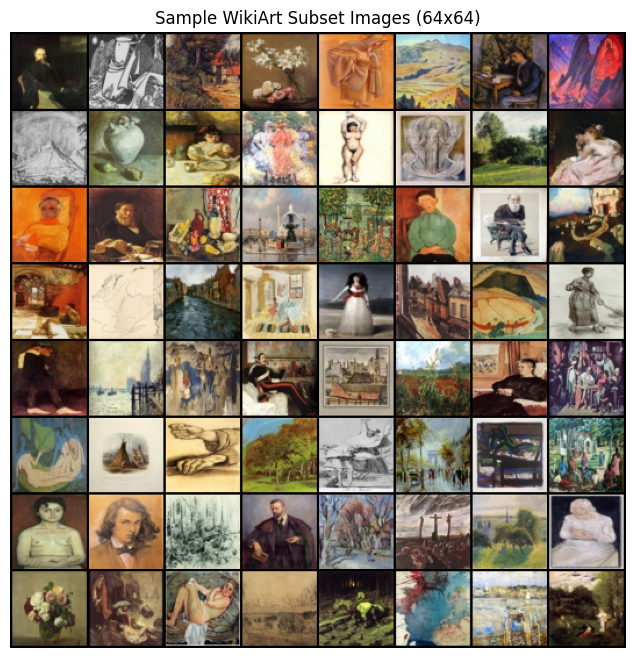

In [2]:
# Function to unnormalize and display a grid of images
def imshow_grid(images, n=8):
    grid = images[:n*n]
    grid = grid * 0.5 + 0.5  # unnormalize from [-1,1] to [0,1]
    grid = torch.clamp(grid, 0, 1)
    grid = torchvision.utils.make_grid(grid, nrow=n)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Sample WikiArt Subset Images (64x64)")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

# Get one batch
import torchvision
data_iter = iter(dataloader)
images, labels = next(data_iter)
imshow_grid(images)

**🧩 What we’ve done**
- Loaded a balanced subset of the WikiArt dataset.
- Applied transformations to make it suitable for DCGAN training.
- Confirmed that all images are 64×64 and normalized.
- Displayed a random batch to visually inspect data quality.

---

#### **4. Define the DCGAN Generator**

We now design the **Generator** of our DCGAN. The Generator starts from a **latent noise vector** $z \in \mathbb{R}^{100}$ sampled from $\mathcal{N}(0,1)$ and **progressively upsamples** it into a **$3\times 64\times 64$** RGB image.

**Layer-by-layer flow**

- **Input:** latent vector $z$ (size = 100)  
- **Projection & reshape:** map $z$ to a small spatial tensor (e.g., $256\times 4\times 4$)  
- **Upsampling stages:**  
  ConvTranspose2d $\rightarrow$ BatchNorm $\rightarrow$ ReLU  
  ConvTranspose2d $\rightarrow$ BatchNorm $\rightarrow$ ReLU  
  ConvTranspose2d $\rightarrow$ BatchNorm $\rightarrow$ ReLU  
  ConvTranspose2d $\rightarrow$ **Tanh**  
- **Output:** $3\times 64\times 64$ image in $[-1, 1]$

```text
z (N,100,1,1)
  → ConvT(100→256, k=4, s=1, p=0) → BN → ReLU      → (N,256,4,4)
  → ConvT(256→128, k=4, s=2, p=1) → BN → ReLU      → (N,128,8,8)
  → ConvT(128→ 64, k=4, s=2, p=1) → BN → ReLU      → (N, 64,16,16)
  → ConvT( 64→ 32, k=4, s=2, p=1) → BN → ReLU      → (N, 32,32,32)
  → ConvT( 32→  3, k=4, s=2, p=1) → Tanh           → (N,  3,64,64)
```

**Why these choices?**
- **Upsampling with transposed convolutions**: Each ConvTranspose2d layer increases spatial size (e.g., $4!\to!8!\to!16!\to!32!\to!64$) while learning where and how to place texture and structure.
- **BatchNorm**: Normalizes activations within each mini-batch, making gradients more stable and accelerating learning.
- **ReLU in hidden layers: Encourages strong, sparse activations that help synthesize vivid structures.
- **Tanh at the output**: Ensures pixel values lie in $[-1,1]$, matching our input normalization; this alignment is crucial so that the Discriminator compares images in the same range.

Below is a clean PyTorch implementation. It follows the canonical DCGAN recipe and prints a model summary so we can verify shapes.

In [3]:
import torch
import torch.nn as nn

class GeneratorDCGAN(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_maps=64):
        """
        z_dim: size of latent vector z
        img_channels: 3 for RGB
        feature_maps: base channel multiplier (64 is DCGAN default)
        """
        super().__init__()
        # We start from (N, z_dim, 1, 1) and grow to (N, 3, 64, 64)
        self.net = nn.Sequential(
            # Input: (N, z_dim, 1, 1) → (N, 256, 4, 4)
            nn.ConvTranspose2d(z_dim, feature_maps*4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),

            # (N, 256, 4, 4) → (N, 128, 8, 8)
            nn.ConvTranspose2d(feature_maps*4, feature_maps*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),

            # (N, 128, 8, 8) → (N, 64, 16, 16)
            nn.ConvTranspose2d(feature_maps*2, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            # (N, 64, 16, 16) → (N, 32, 32, 32)
            nn.ConvTranspose2d(feature_maps, feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps//2),
            nn.ReLU(True),

            # (N, 32, 32, 32) → (N, 3, 64, 64)
            nn.ConvTranspose2d(feature_maps//2, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        # Expect z of shape (N, z_dim); reshape to (N, z_dim, 1, 1)
        if z.dim() == 2:
            z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)

# Sanity check: instantiate and print summary-like info
device = "cuda" if torch.cuda.is_available() else "cpu"
G_dcgan = GeneratorDCGAN(z_dim=100, img_channels=3, feature_maps=64).to(device)
print(G_dcgan)

# Test a forward pass to verify shapes
with torch.no_grad():
    z = torch.randn(4, 100, device=device)       # 4 latent vectors
    fake_imgs = G_dcgan(z)                        # (4, 3, 64, 64)
print("Fake image batch shape:", tuple(fake_imgs.shape))


GeneratorDCGAN(
  (net): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

---

#### **5. Define the DCGAN Discriminator**

Now we define the **Discriminator** — a convolutional network that receives an image of size **$3\times 64\times 64$** and outputs a **probability** that the image is *real* (from the dataset) rather than *fake* (from the Generator).

**Layer intuition (top–down)**  
We progressively **downsample** the image with strided convolutions, increasing channels while reducing spatial size. At each stage we use:

- **Conv2d (stride=2)** to halve spatial dimensions and extract richer features.  
- **BatchNorm** (except the very first layer) to stabilize gradients.  
- **LeakyReLU** activations (slope $=0.2$) so gradients can still flow when activations are negative.

Finally, we flatten to a single logit and apply **Sigmoid** to obtain a probability in $(0,1)$.

```text
Input: (N, 3, 64, 64)
 → Conv2d(3→64,  k=4, s=2, p=1)       → LeakyReLU(0.2)         → (N, 64, 32, 32)
 → Conv2d(64→128,k=4, s=2, p=1)       → BatchNorm → LeakyReLU  → (N,128, 16, 16)
 → Conv2d(128→256,k=4, s=2, p=1)      → BatchNorm → LeakyReLU  → (N,256,  8,  8)
 → Conv2d(256→512,k=4, s=2, p=1)      → BatchNorm → LeakyReLU  → (N,512,  4,  4)
 → Flatten → Linear(512·4·4 → 1)      → Sigmoid                 → (N, 1)
```

**Why LeakyReLU (and not ReLU)?**

Standard ReLU sets negative activations to zero, which can cause **dead features** and **vanishing gradients** when the Discriminator becomes confident. **LeakyReLU** preserves a small negative slope, keeping gradients alive and making the adversarial game more stable.

We also follow the DCGAN convention **not** to use BatchNorm on the **first** Discriminator layer (it tends to hurt early feature extraction) and to use **Sigmoid** only at the end to map logits to probabilities.

In [4]:
import torch
import torch.nn as nn

class DiscriminatorDCGAN(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        """
        img_channels: 3 for RGB
        feature_maps: base channel multiplier (64 is DCGAN default)
        """
        super().__init__()
        self.net = nn.Sequential(
            # (N, 3, 64, 64) -> (N, 64, 32, 32)
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (N, 64, 32, 32) -> (N, 128, 16, 16)
            nn.Conv2d(feature_maps, feature_maps*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (N, 128, 16, 16) -> (N, 256, 8, 8)
            nn.Conv2d(feature_maps*2, feature_maps*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (N, 256, 8, 8) -> (N, 512, 4, 4)
            nn.Conv2d(feature_maps*4, feature_maps*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps*8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_maps*8*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.net(x)
        out = self.classifier(h)
        return out

# Instantiate and print summary-like info
device = "cuda" if torch.cuda.is_available() else "cpu"
D_dcgan = DiscriminatorDCGAN(img_channels=3, feature_maps=64).to(device)
print(D_dcgan)

# Shape check with a dummy batch
with torch.no_grad():
    dummy = torch.randn(4, 3, 64, 64, device=device)
    prob = D_dcgan(dummy)
print("Discriminator output shape:", tuple(prob.shape))


DiscriminatorDCGAN(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, 

---

#### **6. Initialize Weights and Setup Training**

Before we train a DCGAN, we need to set up **sensible defaults** that make the adversarial game learnable and stable. Three ingredients matter here:

**Weight Initialization (DCGAN recipe)**  
Convolutional GANs are very sensitive to initial weights. The original DCGAN paper recommends initializing convolutional and transposed-convolutional **weights** from a **zero-mean Gaussian** with **small variance**:
$$
W \sim \mathcal{N}(0,\; 0.02^2)
$$
This keeps early activations in a reasonable range and helps avoid **vanishing** or **exploding** gradients. For **BatchNorm** layers, it is common to initialize the **scale** (gamma) near 1 and the **bias** (beta) at 0:
$$
\gamma \sim \mathcal{N}(1,\; 0.02^2), \quad \beta = 0
$$
Intuition: early in training, we want BatchNorm to behave almost like an identity transform (scale ≈ 1), but still be learnable.

**Loss Function (Binary Cross-Entropy)**  
We model the Discriminator’s output as a probability that an image is **real**. The **Binary Cross-Entropy** loss measures how well $D$ recognizes real images and how well $G$ fools $D$:
- For real images: target label = 1  
- For generated images: target label = 0 (for $D$’s update)  
- For $G$’s update, we *want* $D(G(z)) \to 1$, so target label = 1

**Optimizer (Adam with tuned betas)**  
DCGANs typically use **Adam** with:
- learning rate $\text{lr} = 0.0002$
- momentum terms $(\beta_1,\beta_2) = (0.5, 0.999)$

Lowering $\beta_1$ from the default 0.9 smooths the moving averages and often stabilizes the adversarial updates.

**Fixed Noise for Monitoring**  
To *see* learning progress, we keep a fixed batch of latent vectors $z$ sampled once at the start. After each epoch, we generate images from this fixed $z$ so changes in quality are easy to compare across time.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Safety checks: expect G_dcgan and D_dcgan from previous sections
assert 'G_dcgan' in globals() and 'D_dcgan' in globals(), "Please run Sections 3 and 4 to define G_dcgan and D_dcgan first."
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# DCGAN-style weight initialization
# -----------------------------
def dcgan_init(m: nn.Module):
    """
    Initialize Conv/ConvTranspose weights ~ N(0, 0.02), bias = 0
    Initialize BatchNorm weight (gamma) ~ N(1, 0.02), bias (beta) = 0
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif classname.find('BatchNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight, mean=1.0, std=0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif classname.find('Linear') != -1:
        # Linear layers are less common in canonical DCGAN, but keep consistent init
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# Apply initialization to both networks
G_dcgan.apply(dcgan_init)
D_dcgan.apply(dcgan_init)

print("Initialized weights for G_dcgan and D_dcgan (DCGAN recipe).")


Initialized weights for G_dcgan and D_dcgan (DCGAN recipe).


In [6]:
# -----------------------------
# Loss function: Binary Cross-Entropy
# -----------------------------
criterion = nn.BCELoss()

# -----------------------------
# Optimizers: Adam with (lr=2e-4, betas=(0.5, 0.999))
# -----------------------------
lr = 2e-4
betas = (0.5, 0.999)
opt_G = optim.Adam(G_dcgan.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D_dcgan.parameters(), lr=lr, betas=betas)

print("Optimizers ready: Adam with lr=0.0002, betas=(0.5, 0.999).")


Optimizers ready: Adam with lr=0.0002, betas=(0.5, 0.999).


In [7]:
# -----------------------------
# Fixed noise for consistent visualization across epochs
# -----------------------------
latent_dim = 100  # ensure this matches your Generator z_dim
fixed_batch = 64  # number of images to visualize per snapshot (8x8 grid works nicely)
fixed_z = torch.randn(fixed_batch, latent_dim, device=device).view(fixed_batch, latent_dim, 1, 1)

print("Fixed noise prepared:", fixed_z.shape)


Fixed noise prepared: torch.Size([64, 100, 1, 1])


**Why this setup works well in practice**

- **Small, zero-mean Gaussian weights** keep early signals well-scaled so both $G$ and $D$ can learn.  
- **BatchNorm near identity** lets the model begin stable and then adapt.  
- **Adam with $(\beta_1,\beta_2)=(0.5,0.999)$** reduces training jitter — a common source of instability in GANs.  
- **Fixed noise $z$** gives us a *visual log* of learning, letting us track improvements in texture, color, and composition over epochs.

In the next section, we will write the **training loop** that alternates updates to the Discriminator and Generator and periodically visualizes samples using the fixed noise.

---

#### **7. Short Training Run (Few Epochs)**

We now perform a **brief DCGAN training run** to qualitatively observe how convolutional architectures learn. The training alternates between the **Discriminator** $D$ and the **Generator** $G$:

- **Update $D$:** show **real** images (target $=1$) and **fake** images $G(z)$ (target $=0$), compute Binary Cross-Entropy (BCE) losses, and step $D$ to separate the two more confidently.
- **Update $G$:** sample fresh $z\sim\mathcal{N}(0, I)$, generate $G(z)$, ask $D$ to predict them as **real** (target $=1$), and step $G$ so its fakes look more realistic to $D$.

We keep this run **short (2–3 epochs)** so it is CPU-friendly. After each epoch, we generate images using a **fixed noise batch** to visualize progression from **noise → blobs → brush-like textures**.


[Epoch 1/3] [Batch 50/141] D_loss: 0.1515 | G_loss: 33.0083
[Epoch 1/3] [Batch 100/141] D_loss: 0.2440 | G_loss: 9.4804


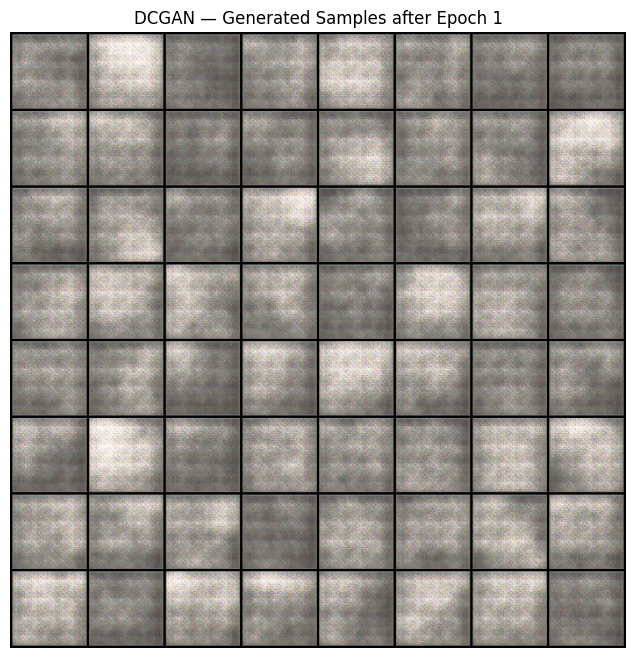

[Epoch 2/3] [Batch 50/141] D_loss: 0.0220 | G_loss: 7.1173
[Epoch 2/3] [Batch 100/141] D_loss: 0.0974 | G_loss: 9.4323


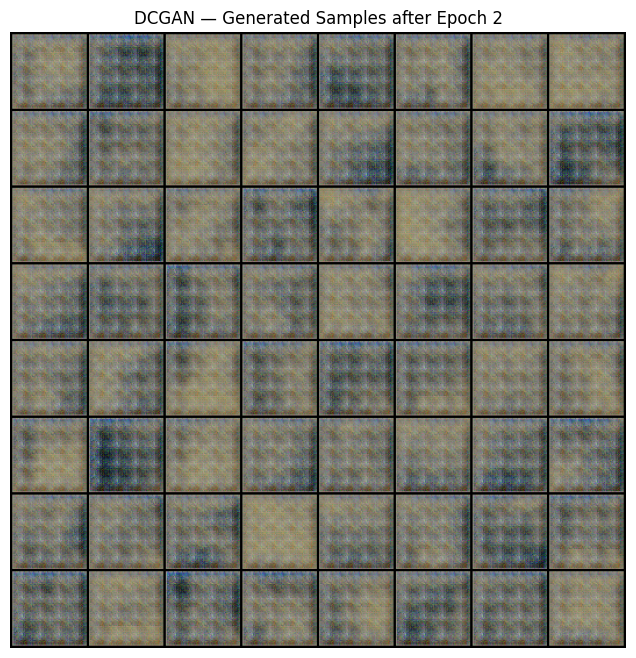

[Epoch 3/3] [Batch 50/141] D_loss: 0.0684 | G_loss: 8.2838
[Epoch 3/3] [Batch 100/141] D_loss: 0.1839 | G_loss: 7.3223


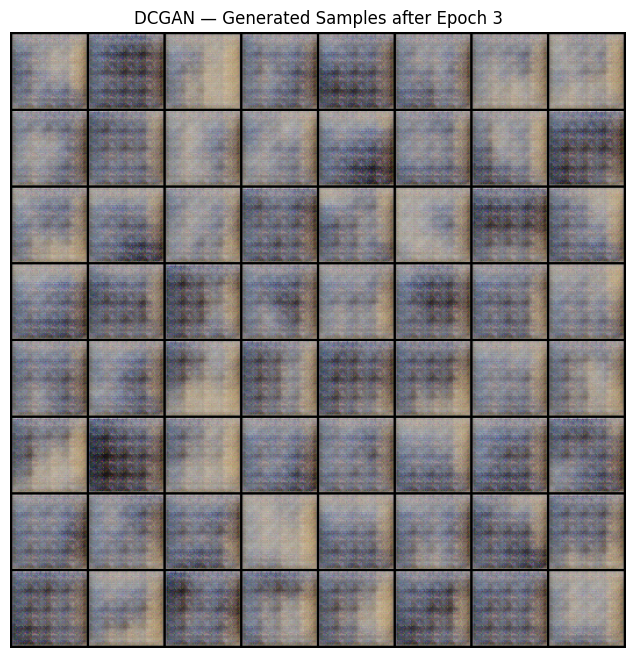

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Safety checks for previously defined objects
assert 'G_dcgan' in globals() and 'D_dcgan' in globals(), "Run Sections 3–5 to define and init G_dcgan/D_dcgan."
assert 'dataloader' in globals(), "Run Section 2 to create dataloader."
assert 'criterion' in globals() and 'opt_G' in globals() and 'opt_D' in globals(), "Run Section 5 to set loss/optimizers."
assert 'fixed_z' in globals(), "Run Section 5 to prepare fixed_z."

device = "cuda" if torch.cuda.is_available() else "cpu"
G_dcgan.train()
D_dcgan.train()

epochs = 3                 # keep it short
log_every = 50             # print frequency
real_label = 1.0
fake_label = 0.0

def denorm(x):
    # [-1,1] -> [0,1]
    return (x + 1) / 2

G_losses, D_losses = [], []

for epoch in range(1, epochs + 1):
    for i, (real_imgs, _) in enumerate(dataloader, start=1):
        bsz = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # ---------------------------
        # 1) Update Discriminator
        # ---------------------------
        opt_D.zero_grad(set_to_none=True)

        # Real batch
        labels_real = torch.full((bsz, 1), real_label, dtype=torch.float, device=device)
        out_real = D_dcgan(real_imgs)
        loss_real = criterion(out_real, labels_real)

        # Fake batch
        z = torch.randn(bsz, 100, device=device).view(bsz, 100, 1, 1)
        fake_imgs = G_dcgan(z).detach()  # detach so G is not updated here
        labels_fake = torch.full((bsz, 1), fake_label, dtype=torch.float, device=device)
        out_fake = D_dcgan(fake_imgs)
        loss_fake = criterion(out_fake, labels_fake)

        # Combine and step D
        loss_D = loss_real + loss_fake
        loss_D.backward()
        opt_D.step()

        # ---------------------------
        # 2) Update Generator
        # ---------------------------
        opt_G.zero_grad(set_to_none=True)
        z = torch.randn(bsz, 100, device=device).view(bsz, 100, 1, 1)
        gen_imgs = G_dcgan(z)
        # For G, pretend fakes are real (target=1)
        labels_gen = torch.full((bsz, 1), real_label, dtype=torch.float, device=device)
        out = D_dcgan(gen_imgs)
        loss_G = criterion(out, labels_gen)
        loss_G.backward()
        opt_G.step()

        # Logging
        if i % log_every == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"D_loss: {loss_D.item():.4f} | G_loss: {loss_G.item():.4f}")

        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())

    # ---------------------------
    # Visualize generated samples after each epoch
    # ---------------------------
    G_dcgan.eval()
    with torch.no_grad():
        samples = G_dcgan(fixed_z).cpu()  # (fixed batch)
    G_dcgan.train()

    grid = torchvision.utils.make_grid(denorm(samples), nrow=8, padding=2)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title(f"DCGAN — Generated Samples after Epoch {epoch}")
    plt.axis("off")
    plt.show()


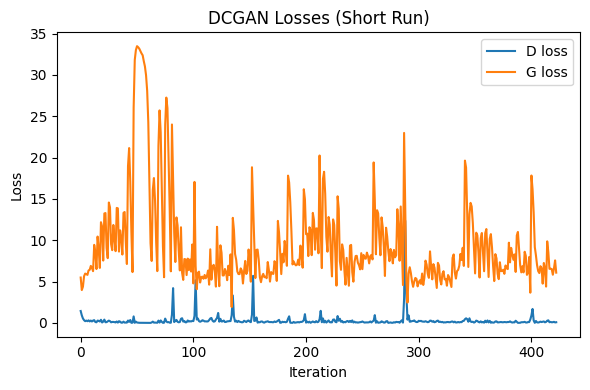

In [11]:
# Optional: quick loss curves to visualize the adversarial tug-of-war
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(D_losses, label="D loss")
plt.plot(G_losses, label="G loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("DCGAN Losses (Short Run)")
plt.legend()
plt.tight_layout()
plt.show()

**What should we look for? (Specially if we run the training for large number of epochs)**

- **Early epochs:** images resemble **noise** or **colored blobs**.  
- **Later in the short run:** we may begin to see **brush-like textures** and more coherent color regions.  
- **Loss curves:** expect **oscillations** rather than monotonic decrease — $G$ and $D$ are improving **against each other**, not against a fixed target.

---

#### **8. Load Pretrained DCGAN and Generate Quality Art**

Training GANs for hundreds of epochs on large art datasets (like **WikiArt**) requires **significant GPU resources and days of training**.  
To make experimentation faster, we will instead **load pretrained DCGAN weights** that were trained **offline** for 100 epochs on a subset of the WikiArt dataset.  
These pretrained weights have already learned strong **texture, color, and composition priors**, allowing us to instantly generate artistic outputs without full retraining.

**Conceptual overview**

- The pretrained model has learned a **latent space of artistic styles** — when we sample a random vector $z \sim \mathcal{N}(0, I) $, the generator interprets it as a *style code* that defines color palette, texture flow, and object layout.
- Because the generator is convolutional, it captures **local texture continuity** — e.g., brush strokes, shading, and surface coherence.
- When compared to our short (2-3 epoch) run, this model should produce **much smoother, visually coherent, and stylistically rich** samples.

We’ll now:
1. Load the pretrained generator weights (`dcgan_pretrained.pth`)
2. Set the model to evaluation mode
3. Generate 16–25 random samples and visualize them as a grid.

In [22]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Load pretrained generator
G_pretrained = GeneratorDCGAN().to(device)
state_dict = torch.load("dcgan_pretrained.pth", map_location=device)
G_pretrained.load_state_dict(state_dict)
G_pretrained.eval()

print("✅ Pretrained DCGAN loaded successfully.")


✅ Pretrained DCGAN loaded successfully.


C:\Users\noman\AppData\Local\Temp\ipykernel_40788\3453725077.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("dcgan_pretrained.pth", map_location

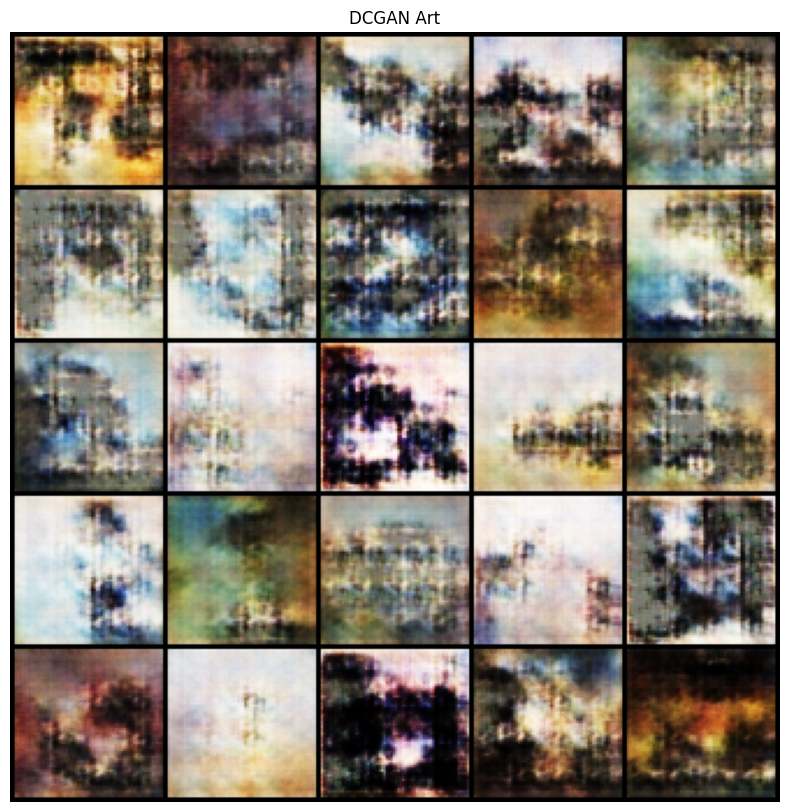

In [23]:
# Generate art samples
num_samples = 25
latent_dim = 100

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim, device=device).view(num_samples, latent_dim, 1, 1)
    art_samples = G_pretrained(z).cpu()

# Denormalize to [0,1]
art_samples = (art_samples + 1) / 2

# Display in a grid
grid = torchvision.utils.make_grid(art_samples, nrow=5, padding=2)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.title("DCGAN Art")
plt.axis("off")
plt.show()

**What improvements do we expect to see if we use a pretrained model?**

Compared to our short training run, we should see the followings from a pre-trained model with long training run:
- **Texture fidelity:** brush strokes and shading appear more **natural and continuous**, resembling oil-paint or watercolor effects.  
- **Color blending:** transitions between hues are **smoother**, avoiding the blocky artifacts we observed earlier.  
- **Composition coherence:** generated pieces maintain consistent **style and spatial balance**, indicating that the model has internalized artistic structure.

---

#### **9. Summary and Reflection**

Let’s wrap up this notebook by reflecting on what we achieved and how our understanding of GANs has evolved.  
In this session, we transitioned from a **simple fully connected GAN** (Notebook 1) to a **convolutional GAN (DCGAN)** that produces far more realistic and stylistically coherent artwork.

**✅ Key Learning Outcomes**

- **Implemented DCGAN Generator and Discriminator:**  
  We built convolutional architectures that capture local spatial dependencies using ConvTranspose2d (for upsampling) and Conv2d (for discrimination).

- **Understood design principles for stable GANs:**  
  Explored the importance of:
  - Weight initialization $\mathcal{N}(0, 0.02)$  
  - Batch normalization for smoother gradient flow  
  - Balanced adversarial updates between $G$ and $D$  
  - Proper learning rate and optimizer settings (Adam with $\beta_1 = 0.5$)

- **Observed training dynamics and quality progression:**  
  Witnessed how outputs evolve from noise → color blobs → brush-like texture patterns.  
  Understood why GAN training involves oscillations and how convergence is *adversarial* rather than monotonic.

- **Used a pretrained model for realistic art synthesis:**  
  Generated high-quality WikiArt-style images showing distinct textures, color harmony, and stylistic coherence — all learned from artistic data.

**🧭 Looking Ahead**

In **Notebook 3**, we’ll move beyond generation to **evaluation** — learning how to assess:
- **Mode collapse** (when the GAN generates repetitive images)  
- **Diversity and realism**  
- **Visual quality metrics** such as FID (Fréchet Inception Distance)

We’ll also experiment with **latent space exploration**, understanding how small changes in $z$ lead to stylistic variations.


---